# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Amaury Combes"
student2 = "Vincenzo Bazzucchi"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

import itertools

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.
/Users/combes/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

In [6]:
x_test.shape

(10181, 256)

In [7]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Here we use the `EarlyStopping` callback to ensure point 7: it will stop the learning process when the validation loss stops decreasing for 5 iterations

In [24]:
# ALL HYPERPARAMETERS NEED TUNING
model = Sequential([
    Dense(y_train.shape[1], input_shape=(x_train.shape[1],), activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.1), #find params
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=9999999999, batch_size=128,
    callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5, min_delta=0.001)]
)

Train on 40427 samples, validate on 14839 samples
Epoch 1/9999999999
40427/40427 [==============================] - 1s 16us/step - loss: 1.5214 - acc: 0.3477 - val_loss: 1.5131 - val_acc: 0.3318
Epoch 2/9999999999
40427/40427 [==============================] - 0s 11us/step - loss: 1.4991 - acc: 0.3669 - val_loss: 1.4983 - val_acc: 0.3522
Epoch 3/9999999999
40427/40427 [==============================] - 0s 10us/step - loss: 1.4906 - acc: 0.3755 - val_loss: 1.4949 - val_acc: 0.3640
Epoch 4/9999999999
40427/40427 [==============================] - 0s 10us/step - loss: 1.4854 - acc: 0.3807 - val_loss: 1.4933 - val_acc: 0.3607
Epoch 5/9999999999
40427/40427 [==============================] - 0s 11us/step - loss: 1.4811 - acc: 0.3878 - val_loss: 1.4937 - val_acc: 0.3693
Epoch 6/9999999999
40427/40427 [==============================] - 0s 11us/step - loss: 1.4773 - acc: 0.3898 - val_loss: 1.4953 - val_acc: 0.3732
Epoch 7/9999999999
40427/40427 [==============================] - 0s 10us/step -

In [25]:
for metric, value in zip(model.metrics_names, model.evaluate(x_test, y_test)):
    print(metric, '=', value)

14839/14839 [==============================] - 0s 18us/step
loss = 1.49337662445
acc = 0.380146910201


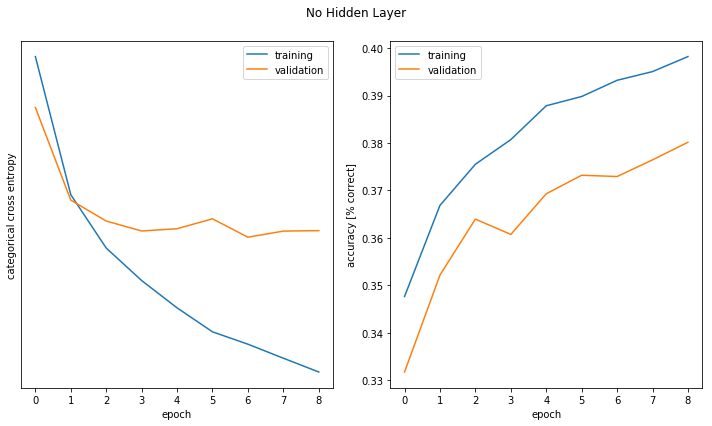

In [26]:
plot_history(history, "No Hidden Layer") # if do not store in var is displayed twice...

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

#### Question 1

In [27]:
model = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.01),
    metrics=['accuracy']
)

historySGD = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


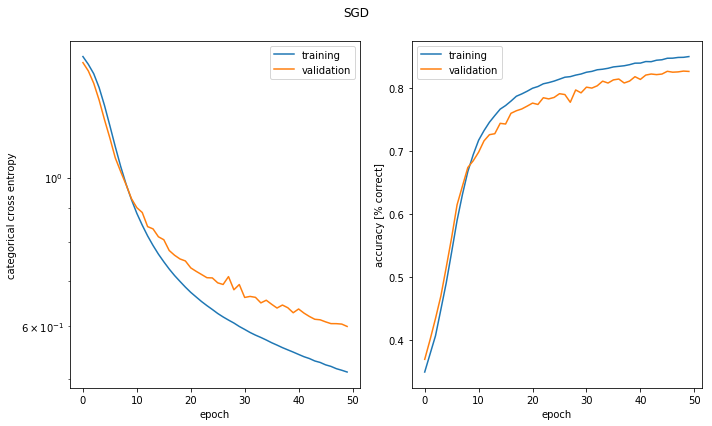

In [29]:
plot_history(historySGD, "SGD") # if do not store in var is displayed twice...

#### Question 2

In [30]:
LARGE_RATE = 0.9
SMALL_RATE = 10**(-6)

In [31]:
sgd_test_rate = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

In [32]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=LARGE_RATE),
    metrics=['accuracy']
)

_ = plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very large learning rate")

In [33]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=SMALL_RATE),
    metrics=['accuracy']
)

_ = plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very small learning rate")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The validation error and accuracy are very "unstable", the search for the optimal value goes in the wrong direction many times

B) The improvement is very slow but constant: we would need three times the number of epochs to reach the best result obtained with the larger learning rate

#### Question 3

In [34]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

historyAdam = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

In [35]:
_ = plot_history(historyAdam, "Adam") # if do not store in var is displayed twice...

Using the same learning rate with Adam and SGD does not allow Adam to improve its accuracy, therefore we changed it here

#### Question 4

In [36]:
fig, ax1, ax2 = prepare_standardplot("Comparing SGD and ADAM", 'epoch')
ax1.plot(historySGD.history['loss'], label = "training with SGD", linestyle='--', c='b')
ax1.plot(historySGD.history['val_loss'], label = "validation with SGD", linestyle='-', c='b')
ax2.plot(historySGD.history['acc'], label = "training with SGD", linestyle='--', c='b')
ax2.plot(historySGD.history['val_acc'], label = "validation with SGD", linestyle='-', c='b')

ax1.plot(historyAdam.history['loss'], label = "training with Adam", linestyle='--', c='orange')
ax1.plot(historyAdam.history['val_loss'], label = "validation with Adam", linestyle='-', c='orange')
ax2.plot(historyAdam.history['acc'], label = "training with Adam", linestyle='--', c='orange')
ax2.plot(historyAdam.history['val_acc'], label = "validation with Adam", linestyle='-', c='orange')
finalize_standardplot(fig, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [37]:
_ = plot_history(historyAdam, "Adam") # if do not store in var is displayed twice...

The training we ran before was already overfitting: we can clearly see that the training error keeps decreasing while the validation error stays stable. We can see the same pattern observing the accuracy: the training accuracy keeps increasing while the validation accuracy is mostly stable

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model start to overfit right away but after epoch 15 we clearly see that the validation error stays stable or increases while the training error keeps decreasing

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: # TODO

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

As we observed from our previous plots, the Adam optimizer converges much quicker than the SGD one. Therefore we will use it here. We saw that the model start to overfit at around 15 so we will train it for 30 epochs

In [38]:
def get_model_result(hidden_neurons):
    m = Sequential([
        Dense(hidden_neurons, input_shape=(x_train.shape[1],), activation="relu"),
        Dense(y_train.shape[1], activation="softmax")
    ])
    
    m.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=0.001),
        metrics=['accuracy']
    )

    h = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=30,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3, min_delta=0.001)]
    )
    
    return h.history['val_loss'][-1], h.history['val_acc'][-1]

#### Questions 1 and 2

In [39]:
N = 20
hidden_neurons = list(map(int, np.logspace(1, 3, N)))
stats = []
for idx, hid in enumerate(hidden_neurons):
    # This seed or the seed parameter of initializer?
    # https://keras.io/initializers/
    np.random.seed(hash(student1 + student2) % 2**32)
    stats.append(get_model_result(hid))
    print("Completed train {}/{}".format(idx+1, N))

Completed train 1/20
Completed train 2/20
Completed train 3/20
Completed train 4/20


KeyboardInterrupt: 

#### Question 3

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2)#, sharey=True)

losses, accuracies = zip(*stats)

ax_loss.boxplot(losses)
ax_loss.set_title("Validation loss")
#ax_loss.set_yticklabels(hidden_neurons) # I am not sure it makes any sense: to build boxplot points are not kept in the same order


ax_acc.boxplot(accuracies)
ax_acc.set_title("Validation accuracy")
#ax_acc.set_yticklabels(hidden_neurons)

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2, sharey=True)

ax_loss.plot(hidden_neurons, losses)
ax_loss.set_title("Validation loss")
ax_acc.plot(hidden_neurons, accuracies)
ax_acc.set_title("Validation accuracy")

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

### 1.

#### Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons

In [9]:
def dense_factory(input_, output, weight_regularizer, bias_regularizer):
    return Dense(output, input_shape=(input_,), activation="softmax", kernel_initializer='random_uniform', kernel_regularizer=weight_regularizer, bias_regularizer=bias_regularizer)

def model_factory(units, layers, weight_regularizer, bias_regularizer, dropout=None):
    # Check input validity for dropout
    if dropout is not None and len(dropout) < 2:
        dropout.append(0)
        
    model_builder = Sequential()
    
    # Input layer
    model_builder.add(dense_factory(x_train.shape[1], units, weight_regularizer, bias_regularizer)) 
    if dropout is not None:
        model_builder.add(Dropout(dropout[0]))
        
    # Hidden layers
    for i in range(layers-1):
        model_builder.add(dense_factory((units,), units, weight_regularizer, bias_regularizer))
        if dropout is not None:
            model_builder.add(Dropout(dropout[1]))
        
    # Output layer
    model_builder.add(dense_factory((units,), y_train.shape[1], weight_regularizer, bias_regularizer))
    if dropout is not None:
        model_builder.add(Dropout(dropout[1]))
    
    return model_builder

# Dummy regularizer, used as non existing regularizer
null_reg = keras.regularizers.l1(0)

# Factories for required models
size_per_layer_1_hidden = 100
size_per_layer_2_hidden = 77
size_per_layer_3_hidden = 66
size_per_layer_4_hidden = 59

def model_1_hidden_factory(weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_1_hidden, 1, weight_regularizer, bias_regularizer, dropout)

def model_2_hidden_factory(weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_2_hidden, 2, weight_regularizer, bias_regularizer, dropout)

def model_3_hidden_factory(weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_3_hidden, 3, weight_regularizer, bias_regularizer, dropout)

def model_4_hidden_factory(weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_4_hidden, 4, weight_regularizer, bias_regularizer, dropout)

def compile_model(model):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=0.01),
        metrics=['accuracy']
    )
    
def fit_model(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    h = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=80,
        verbose=1,
        callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5, min_delta=0.001)]
    )   
    return h

#### Confirm you result with the keras method model.summary()

In [10]:
model_1_hidden_factory().summary()
model_2_hidden_factory().summary()
model_3_hidden_factory().summary()
model_4_hidden_factory().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 77)                19789     
_________________________________________________________________
dense_4 (Dense)              (None, 77)                6006      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

### 2.
#### Run each model multiple times with different initial conditions

In [11]:
model_factories = [model_1_hidden_factory, model_2_hidden_factory, model_3_hidden_factory, model_4_hidden_factory]

try_per_model = 40

results = []

for i, factory in enumerate(model_factories):
    print('Training model', i + 1, '/', len(model_factories))
    
    curr_model_res = []
    
    for i in range(try_per_model):
        print('Inner step:', i+1, '/', try_per_model)
        
        model = factory()
        
        compile_model(model)
        
        h = fit_model(model, x_train, y_train, x_test, y_test)
        
        curr_model_res.append(h)
        
    results.append(curr_model_res)

Training model 1 / 4
Inner step: 1 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 2s 76us/step - loss: 1.3334 - acc: 0.4002 - val_loss: 1.2195 - val_acc: 0.4806
Epoch 2/80
29639/29639 [==============================] - 2s 66us/step - loss: 1.1769 - acc: 0.4827 - val_loss: 1.1925 - val_acc: 0.5063
Epoch 3/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.1583 - acc: 0.5007 - val_loss: 1.2088 - val_acc: 0.4931
Epoch 4/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.1437 - acc: 0.5142 - val_loss: 1.2118 - val_acc: 0.4985
Epoch 5/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.1448 - acc: 0.5198 - val_loss: 1.1916 - val_acc: 0.5193
Epoch 6/80
29639/29639 [==============================] - 2s 55us/step - loss: 1.1336 - acc: 0.5268 - val_loss: 1.1775 - val_acc: 0.5216
Epoch 7/80
29639/29639 [==============================] - 2s 55us/step - loss: 1.1337 - 

Epoch 24/80
29639/29639 [==============================] - 2s 52us/step - loss: 0.9101 - acc: 0.6362 - val_loss: 0.9941 - val_acc: 0.6160
Epoch 25/80
29639/29639 [==============================] - 2s 53us/step - loss: 0.9054 - acc: 0.6385 - val_loss: 0.9735 - val_acc: 0.6299
Epoch 26/80
29639/29639 [==============================] - 2s 52us/step - loss: 0.8942 - acc: 0.6415 - val_loss: 0.9819 - val_acc: 0.6246
Epoch 27/80
29639/29639 [==============================] - 2s 52us/step - loss: 0.8963 - acc: 0.6428 - val_loss: 0.9855 - val_acc: 0.6207
Epoch 28/80
29639/29639 [==============================] - 2s 53us/step - loss: 0.8924 - acc: 0.6422 - val_loss: 0.9798 - val_acc: 0.6234
Epoch 29/80
29639/29639 [==============================] - 2s 53us/step - loss: 0.8859 - acc: 0.6436 - val_loss: 1.0115 - val_acc: 0.6089
Epoch 30/80
29639/29639 [==============================] - 2s 52us/step - loss: 0.8852 - acc: 0.6449 - val_loss: 1.0111 - val_acc: 0.6143
Inner step: 4 / 40
Train on 29639 

29639/29639 [==============================] - 2s 68us/step - loss: 1.2146 - acc: 0.4847 - val_loss: 1.0976 - val_acc: 0.5643
Epoch 2/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.0202 - acc: 0.5747 - val_loss: 1.0519 - val_acc: 0.5777
Epoch 3/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.0015 - acc: 0.5820 - val_loss: 1.0355 - val_acc: 0.5830
Epoch 4/80
29639/29639 [==============================] - 2s 57us/step - loss: 0.9995 - acc: 0.5824 - val_loss: 1.0491 - val_acc: 0.5791
Epoch 5/80
29639/29639 [==============================] - 2s 57us/step - loss: 0.9861 - acc: 0.5866 - val_loss: 1.0424 - val_acc: 0.5798
Epoch 6/80
29639/29639 [==============================] - 2s 57us/step - loss: 0.9815 - acc: 0.5901 - val_loss: 1.0821 - val_acc: 0.5668
Epoch 7/80
29639/29639 [==============================] - 2s 56us/step - loss: 0.9811 - acc: 0.5884 - val_loss: 1.0562 - val_acc: 0.5777
Epoch 8/80
29639/29639 [============================

29639/29639 [==============================] - 2s 62us/step - loss: 0.7405 - acc: 0.7339 - val_loss: 0.8649 - val_acc: 0.7015
Epoch 30/80
29639/29639 [==============================] - 2s 54us/step - loss: 0.7332 - acc: 0.7363 - val_loss: 0.8804 - val_acc: 0.6974
Epoch 31/80
29639/29639 [==============================] - 1s 50us/step - loss: 0.7325 - acc: 0.7354 - val_loss: 0.8950 - val_acc: 0.6978
Epoch 32/80
29639/29639 [==============================] - 2s 55us/step - loss: 0.7225 - acc: 0.7402 - val_loss: 0.9063 - val_acc: 0.6878
Epoch 33/80
29639/29639 [==============================] - 2s 61us/step - loss: 0.7165 - acc: 0.7422 - val_loss: 0.8707 - val_acc: 0.6977
Epoch 34/80
29639/29639 [==============================] - 2s 57us/step - loss: 0.7180 - acc: 0.7423 - val_loss: 0.8686 - val_acc: 0.7037
Inner step: 13 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 2s 81us/step - loss: 1.2066 - acc: 0.4935 - val_loss: 1.

29639/29639 [==============================] - 2s 75us/step - loss: 1.3263 - acc: 0.4103 - val_loss: 1.2300 - val_acc: 0.4635
Epoch 2/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.1832 - acc: 0.4697 - val_loss: 1.2097 - val_acc: 0.4673
Epoch 3/80
29639/29639 [==============================] - 2s 53us/step - loss: 1.1637 - acc: 0.4755 - val_loss: 1.2026 - val_acc: 0.4707
Epoch 4/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.1627 - acc: 0.4777 - val_loss: 1.1964 - val_acc: 0.4789
Epoch 5/80
29639/29639 [==============================] - 2s 53us/step - loss: 1.1561 - acc: 0.4833 - val_loss: 1.1992 - val_acc: 0.4771
Epoch 6/80
29639/29639 [==============================] - 2s 52us/step - loss: 1.1473 - acc: 0.4856 - val_loss: 1.2109 - val_acc: 0.4751
Epoch 7/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.1496 - acc: 0.4851 - val_loss: 1.2342 - val_acc: 0.4645
Epoch 8/80
29639/29639 [============================

Epoch 14/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3188 - acc: 0.3881 - val_loss: 1.3734 - val_acc: 0.3857
Epoch 15/80
29639/29639 [==============================] - 2s 78us/step - loss: 1.3175 - acc: 0.3834 - val_loss: 1.3651 - val_acc: 0.3878
Epoch 16/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.1900 - acc: 0.4764 - val_loss: 1.2170 - val_acc: 0.4908
Epoch 17/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.1457 - acc: 0.4923 - val_loss: 1.2107 - val_acc: 0.4949
Epoch 18/80
29639/29639 [==============================] - 2s 54us/step - loss: 1.1273 - acc: 0.5113 - val_loss: 1.1737 - val_acc: 0.5182
Epoch 19/80
29639/29639 [==============================] - 2s 61us/step - loss: 1.0968 - acc: 0.5288 - val_loss: 1.1813 - val_acc: 0.5119
Epoch 20/80
29639/29639 [==============================] - 2s 66us/step - loss: 1.0828 - acc: 0.5378 - val_loss: 1.1425 - val_acc: 0.5293
Epoch 21/80
29639/29639 [=========

Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 2s 84us/step - loss: 1.4115 - acc: 0.3447 - val_loss: 1.3777 - val_acc: 0.3607
Epoch 2/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.3395 - acc: 0.3787 - val_loss: 1.3639 - val_acc: 0.3775
Epoch 3/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.3312 - acc: 0.3789 - val_loss: 1.3662 - val_acc: 0.3828
Epoch 4/80
29639/29639 [==============================] - 2s 56us/step - loss: 1.3288 - acc: 0.3812 - val_loss: 1.3635 - val_acc: 0.3846
Epoch 5/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.3254 - acc: 0.3835 - val_loss: 1.3752 - val_acc: 0.3850
Epoch 6/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.3236 - acc: 0.3848 - val_loss: 1.3851 - val_acc: 0.3862
Epoch 7/80
29639/29639 [==============================] - 2s 55us/step - loss: 1.3229 - acc: 0.3850 - val_loss: 1.3637 - val_acc

Epoch 7/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.3227 - acc: 0.3865 - val_loss: 1.3644 - val_acc: 0.3867
Epoch 8/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.3220 - acc: 0.3842 - val_loss: 1.3593 - val_acc: 0.3859
Epoch 9/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.3191 - acc: 0.3852 - val_loss: 1.3698 - val_acc: 0.3843
Epoch 10/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3200 - acc: 0.3879 - val_loss: 1.3562 - val_acc: 0.3811
Epoch 11/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3180 - acc: 0.3862 - val_loss: 1.3834 - val_acc: 0.3840
Epoch 12/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3174 - acc: 0.3876 - val_loss: 1.3738 - val_acc: 0.3884
Epoch 13/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3170 - acc: 0.3867 - val_loss: 1.3727 - val_acc: 0.3884
Epoch 14/80
29639/29639 [============

Epoch 32/80
29639/29639 [==============================] - 2s 58us/step - loss: 0.8165 - acc: 0.6839 - val_loss: 0.9507 - val_acc: 0.6492
Epoch 33/80
29639/29639 [==============================] - 2s 58us/step - loss: 0.8126 - acc: 0.6871 - val_loss: 0.9393 - val_acc: 0.6533
Epoch 34/80
29639/29639 [==============================] - 2s 58us/step - loss: 0.8072 - acc: 0.6887 - val_loss: 0.9464 - val_acc: 0.6532
Epoch 35/80
29639/29639 [==============================] - 2s 63us/step - loss: 0.8088 - acc: 0.6891 - val_loss: 0.9455 - val_acc: 0.6500
Inner step: 31 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 3s 87us/step - loss: 1.4286 - acc: 0.3431 - val_loss: 1.3756 - val_acc: 0.3729
Epoch 2/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.3418 - acc: 0.3730 - val_loss: 1.3773 - val_acc: 0.3726
Epoch 3/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.3324 - acc: 0.3718 - va

29639/29639 [==============================] - 2s 58us/step - loss: 0.7042 - acc: 0.7496 - val_loss: 0.8748 - val_acc: 0.6984
Inner step: 36 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 3s 90us/step - loss: 1.4835 - acc: 0.3303 - val_loss: 1.4542 - val_acc: 0.3534
Epoch 2/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.4356 - acc: 0.3617 - val_loss: 1.4557 - val_acc: 0.3642
Epoch 3/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.4313 - acc: 0.3647 - val_loss: 1.4537 - val_acc: 0.3680
Epoch 4/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.4296 - acc: 0.3669 - val_loss: 1.4499 - val_acc: 0.3638
Epoch 5/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.4276 - acc: 0.3673 - val_loss: 1.4541 - val_acc: 0.3669
Epoch 6/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.3865 - acc: 0.3708 - val_loss: 1.3697 

29639/29639 [==============================] - 3s 117us/step - loss: 1.4161 - acc: 0.3440 - val_loss: 1.3713 - val_acc: 0.3644
Epoch 2/80
29639/29639 [==============================] - 2s 60us/step - loss: 1.3384 - acc: 0.3744 - val_loss: 1.3687 - val_acc: 0.3822
Epoch 3/80
29639/29639 [==============================] - 2s 83us/step - loss: 1.3319 - acc: 0.3786 - val_loss: 1.3864 - val_acc: 0.3840
Epoch 4/80
29639/29639 [==============================] - 2s 64us/step - loss: 1.3293 - acc: 0.3809 - val_loss: 1.3788 - val_acc: 0.3822
Epoch 5/80
29639/29639 [==============================] - 2s 58us/step - loss: 1.3241 - acc: 0.3846 - val_loss: 1.4135 - val_acc: 0.3739
Epoch 6/80
29639/29639 [==============================] - 2s 59us/step - loss: 1.3230 - acc: 0.3848 - val_loss: 1.3687 - val_acc: 0.3844
Epoch 7/80
29639/29639 [==============================] - 2s 57us/step - loss: 1.3229 - acc: 0.3862 - val_loss: 1.3678 - val_acc: 0.3857
Inner step: 39 / 40
Train on 29639 samples, validat

29639/29639 [==============================] - 2s 62us/step - loss: 0.9699 - acc: 0.6288 - val_loss: 1.0312 - val_acc: 0.6117
Epoch 18/80
29639/29639 [==============================] - 2s 64us/step - loss: 0.9473 - acc: 0.6373 - val_loss: 1.0456 - val_acc: 0.6157
Epoch 19/80
29639/29639 [==============================] - 2s 60us/step - loss: 0.9243 - acc: 0.6503 - val_loss: 1.0142 - val_acc: 0.6195
Epoch 20/80
29639/29639 [==============================] - 2s 60us/step - loss: 0.9157 - acc: 0.6518 - val_loss: 1.0792 - val_acc: 0.6007
Epoch 21/80
29639/29639 [==============================] - 2s 67us/step - loss: 0.9123 - acc: 0.6562 - val_loss: 1.0050 - val_acc: 0.6312
Epoch 22/80
29639/29639 [==============================] - 2s 71us/step - loss: 0.8917 - acc: 0.6667 - val_loss: 0.9874 - val_acc: 0.6348
Epoch 23/80
29639/29639 [==============================] - 2s 63us/step - loss: 0.8795 - acc: 0.6739 - val_loss: 0.9899 - val_acc: 0.6325
Epoch 24/80
29639/29639 [=====================

29639/29639 [==============================] - 2s 70us/step - loss: 0.7585 - acc: 0.7414 - val_loss: 0.8495 - val_acc: 0.7129
Epoch 33/80
29639/29639 [==============================] - 2s 71us/step - loss: 0.7349 - acc: 0.7529 - val_loss: 0.8491 - val_acc: 0.7096
Epoch 34/80
29639/29639 [==============================] - 2s 73us/step - loss: 0.7188 - acc: 0.7574 - val_loss: 0.9669 - val_acc: 0.6811
Epoch 35/80
29639/29639 [==============================] - 2s 66us/step - loss: 0.7127 - acc: 0.7621 - val_loss: 0.8420 - val_acc: 0.7234
Epoch 36/80
29639/29639 [==============================] - 2s 65us/step - loss: 0.7045 - acc: 0.7633 - val_loss: 0.8005 - val_acc: 0.7370
Epoch 37/80
29639/29639 [==============================] - 2s 62us/step - loss: 0.6954 - acc: 0.7682 - val_loss: 0.8476 - val_acc: 0.7106
Epoch 38/80
29639/29639 [==============================] - 2s 67us/step - loss: 0.6889 - acc: 0.7709 - val_loss: 0.8266 - val_acc: 0.7268
Epoch 39/80
29639/29639 [=====================

29639/29639 [==============================] - 3s 108us/step - loss: 1.5378 - acc: 0.2872 - val_loss: 1.5212 - val_acc: 0.3059
Epoch 2/80
29639/29639 [==============================] - 2s 68us/step - loss: 1.5054 - acc: 0.3043 - val_loss: 1.5363 - val_acc: 0.3049
Epoch 3/80
29639/29639 [==============================] - 2s 63us/step - loss: 1.5022 - acc: 0.3051 - val_loss: 1.5394 - val_acc: 0.3056
Epoch 4/80
29639/29639 [==============================] - 2s 67us/step - loss: 1.5012 - acc: 0.3073 - val_loss: 1.5376 - val_acc: 0.3062
Epoch 5/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.5007 - acc: 0.3082 - val_loss: 1.5290 - val_acc: 0.3055
Epoch 6/80
29639/29639 [==============================] - 2s 68us/step - loss: 1.4993 - acc: 0.3082 - val_loss: 1.5502 - val_acc: 0.3037
Inner step: 7 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 3s 108us/step - loss: 1.3981 - acc: 0.3779 - val_loss: 1.3368

29639/29639 [==============================] - 3s 114us/step - loss: 1.5366 - acc: 0.2887 - val_loss: 1.5956 - val_acc: 0.2812
Epoch 2/80
29639/29639 [==============================] - 2s 70us/step - loss: 1.4833 - acc: 0.3216 - val_loss: 1.4016 - val_acc: 0.3754
Epoch 3/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.3560 - acc: 0.4038 - val_loss: 1.3879 - val_acc: 0.3878
Epoch 4/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.3410 - acc: 0.4081 - val_loss: 1.3690 - val_acc: 0.4031
Epoch 5/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.3391 - acc: 0.4066 - val_loss: 1.3633 - val_acc: 0.4029
Epoch 6/80
29639/29639 [==============================] - 2s 67us/step - loss: 1.3294 - acc: 0.4124 - val_loss: 1.3820 - val_acc: 0.3842
Epoch 7/80
29639/29639 [==============================] - 2s 64us/step - loss: 1.3312 - acc: 0.4085 - val_loss: 1.3837 - val_acc: 0.3912
Epoch 8/80
29639/29639 [===========================

29639/29639 [==============================] - 2s 66us/step - loss: 0.5417 - acc: 0.8171 - val_loss: 0.7177 - val_acc: 0.7678
Epoch 44/80
29639/29639 [==============================] - 2s 77us/step - loss: 0.5368 - acc: 0.8167 - val_loss: 0.7168 - val_acc: 0.7676
Epoch 45/80
29639/29639 [==============================] - 2s 81us/step - loss: 0.5329 - acc: 0.8189 - val_loss: 0.7214 - val_acc: 0.7669
Epoch 46/80
29639/29639 [==============================] - 2s 75us/step - loss: 0.5305 - acc: 0.8206 - val_loss: 0.7200 - val_acc: 0.7711
Epoch 47/80
29639/29639 [==============================] - 2s 69us/step - loss: 0.5272 - acc: 0.8200 - val_loss: 0.7164 - val_acc: 0.7661
Inner step: 16 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 3s 116us/step - loss: 1.5030 - acc: 0.3004 - val_loss: 1.4782 - val_acc: 0.3305
Epoch 2/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.4007 - acc: 0.3849 - val_loss: 1.

29639/29639 [==============================] - 2s 65us/step - loss: 0.5668 - acc: 0.8126 - val_loss: 0.8209 - val_acc: 0.7479
Epoch 56/80
29639/29639 [==============================] - 2s 63us/step - loss: 0.5651 - acc: 0.8137 - val_loss: 0.7611 - val_acc: 0.7622
Epoch 57/80
29639/29639 [==============================] - 2s 66us/step - loss: 0.5662 - acc: 0.8119 - val_loss: 0.7480 - val_acc: 0.7657
Epoch 58/80
29639/29639 [==============================] - 2s 66us/step - loss: 0.5646 - acc: 0.8146 - val_loss: 0.8783 - val_acc: 0.7373
Epoch 59/80
29639/29639 [==============================] - 2s 64us/step - loss: 0.5614 - acc: 0.8159 - val_loss: 0.7862 - val_acc: 0.7464
Epoch 60/80
29639/29639 [==============================] - 2s 63us/step - loss: 0.5546 - acc: 0.8166 - val_loss: 0.7591 - val_acc: 0.7640
Epoch 61/80
29639/29639 [==============================] - 2s 64us/step - loss: 0.5572 - acc: 0.8165 - val_loss: 0.8127 - val_acc: 0.7449
Epoch 62/80
29639/29639 [=====================

29639/29639 [==============================] - 2s 68us/step - loss: 0.5635 - acc: 0.8067 - val_loss: 0.7795 - val_acc: 0.7444
Inner step: 18 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 4s 128us/step - loss: 1.5344 - acc: 0.2850 - val_loss: 1.5095 - val_acc: 0.3112
Epoch 2/80
29639/29639 [==============================] - 2s 67us/step - loss: 1.5061 - acc: 0.3046 - val_loss: 1.5062 - val_acc: 0.3073
Epoch 3/80
29639/29639 [==============================] - 2s 64us/step - loss: 1.5038 - acc: 0.3040 - val_loss: 1.5127 - val_acc: 0.3292
Epoch 4/80
29639/29639 [==============================] - 2s 65us/step - loss: 1.3984 - acc: 0.3807 - val_loss: 1.3546 - val_acc: 0.4022
Epoch 5/80
29639/29639 [==============================] - 2s 66us/step - loss: 1.2907 - acc: 0.4385 - val_loss: 1.2657 - val_acc: 0.4612
Epoch 6/80
29639/29639 [==============================] - 2s 68us/step - loss: 1.1817 - acc: 0.4966 - val_loss: 1.2050

29639/29639 [==============================] - 2s 67us/step - loss: 0.6253 - acc: 0.7874 - val_loss: 0.8696 - val_acc: 0.7185
Epoch 43/80
29639/29639 [==============================] - 2s 65us/step - loss: 0.6272 - acc: 0.7890 - val_loss: 0.8104 - val_acc: 0.7244
Epoch 44/80
29639/29639 [==============================] - 2s 65us/step - loss: 0.6257 - acc: 0.7896 - val_loss: 0.7969 - val_acc: 0.7352
Epoch 45/80
29639/29639 [==============================] - 2s 66us/step - loss: 0.6232 - acc: 0.7890 - val_loss: 0.7824 - val_acc: 0.7345
Epoch 46/80
29639/29639 [==============================] - 2s 65us/step - loss: 0.6149 - acc: 0.7926 - val_loss: 0.7894 - val_acc: 0.7395
Epoch 47/80
29639/29639 [==============================] - 2s 66us/step - loss: 0.6148 - acc: 0.7932 - val_loss: 0.8503 - val_acc: 0.7311
Epoch 48/80
29639/29639 [==============================] - 2s 65us/step - loss: 0.6011 - acc: 0.7982 - val_loss: 0.8820 - val_acc: 0.7118
Epoch 49/80
29639/29639 [=====================

29639/29639 [==============================] - 2s 75us/step - loss: 0.6194 - acc: 0.7895 - val_loss: 0.7824 - val_acc: 0.7376
Epoch 44/80
29639/29639 [==============================] - 2s 69us/step - loss: 0.6167 - acc: 0.7914 - val_loss: 0.7854 - val_acc: 0.7364
Inner step: 24 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 4s 131us/step - loss: 1.5360 - acc: 0.2879 - val_loss: 1.5152 - val_acc: 0.3038
Epoch 2/80
29639/29639 [==============================] - 2s 69us/step - loss: 1.4982 - acc: 0.3115 - val_loss: 1.4328 - val_acc: 0.3685
Epoch 3/80
29639/29639 [==============================] - 2s 68us/step - loss: 1.3318 - acc: 0.4316 - val_loss: 1.2150 - val_acc: 0.4945
Epoch 4/80
29639/29639 [==============================] - 2s 71us/step - loss: 1.1421 - acc: 0.5361 - val_loss: 1.1420 - val_acc: 0.5370
Epoch 5/80
29639/29639 [==============================] - 2s 71us/step - loss: 1.1055 - acc: 0.5516 - val_loss: 1.112

29639/29639 [==============================] - 2s 71us/step - loss: 0.7000 - acc: 0.7586 - val_loss: 0.8599 - val_acc: 0.7048
Epoch 32/80
29639/29639 [==============================] - 2s 74us/step - loss: 0.6917 - acc: 0.7626 - val_loss: 0.7991 - val_acc: 0.7329
Epoch 33/80
29639/29639 [==============================] - 2s 72us/step - loss: 0.6817 - acc: 0.7654 - val_loss: 0.8228 - val_acc: 0.7209
Epoch 34/80
29639/29639 [==============================] - 2s 72us/step - loss: 0.6763 - acc: 0.7670 - val_loss: 0.8677 - val_acc: 0.7095
Epoch 35/80
29639/29639 [==============================] - 2s 69us/step - loss: 0.6775 - acc: 0.7668 - val_loss: 0.9018 - val_acc: 0.6908
Epoch 36/80
29639/29639 [==============================] - 2s 71us/step - loss: 0.6552 - acc: 0.7752 - val_loss: 0.8005 - val_acc: 0.7382
Epoch 37/80
29639/29639 [==============================] - 2s 72us/step - loss: 0.6557 - acc: 0.7746 - val_loss: 0.8178 - val_acc: 0.7324
Inner step: 28 / 40
Train on 29639 samples, va

29639/29639 [==============================] - 4s 135us/step - loss: 1.4923 - acc: 0.3216 - val_loss: 1.3383 - val_acc: 0.4050
Epoch 2/80
29639/29639 [==============================] - 2s 71us/step - loss: 1.3089 - acc: 0.4157 - val_loss: 1.3139 - val_acc: 0.4171
Epoch 3/80
29639/29639 [==============================] - 2s 70us/step - loss: 1.2826 - acc: 0.4210 - val_loss: 1.2924 - val_acc: 0.4191
Epoch 4/80
29639/29639 [==============================] - 2s 70us/step - loss: 1.2669 - acc: 0.4301 - val_loss: 1.2852 - val_acc: 0.4437
Epoch 5/80
29639/29639 [==============================] - 2s 69us/step - loss: 1.2468 - acc: 0.4574 - val_loss: 1.2557 - val_acc: 0.4951
Epoch 6/80
29639/29639 [==============================] - 2s 69us/step - loss: 1.1661 - acc: 0.5102 - val_loss: 1.1688 - val_acc: 0.5297
Epoch 7/80
29639/29639 [==============================] - 2s 69us/step - loss: 1.1193 - acc: 0.5312 - val_loss: 1.1567 - val_acc: 0.5181
Epoch 8/80
29639/29639 [===========================

29639/29639 [==============================] - 3s 90us/step - loss: 0.6600 - acc: 0.7768 - val_loss: 0.8051 - val_acc: 0.7349
Epoch 32/80
29639/29639 [==============================] - 3s 87us/step - loss: 0.6559 - acc: 0.7761 - val_loss: 0.7761 - val_acc: 0.7445
Epoch 33/80
29639/29639 [==============================] - 3s 87us/step - loss: 0.6518 - acc: 0.7808 - val_loss: 0.8715 - val_acc: 0.7123
Epoch 34/80
29639/29639 [==============================] - 3s 90us/step - loss: 0.6527 - acc: 0.7774 - val_loss: 0.7940 - val_acc: 0.7283
Epoch 35/80
29639/29639 [==============================] - 3s 92us/step - loss: 0.6363 - acc: 0.7828 - val_loss: 0.8107 - val_acc: 0.7299
Epoch 36/80
29639/29639 [==============================] - 3s 97us/step - loss: 0.6421 - acc: 0.7810 - val_loss: 0.8084 - val_acc: 0.7242
Epoch 37/80
29639/29639 [==============================] - 3s 85us/step - loss: 0.6335 - acc: 0.7852 - val_loss: 0.7924 - val_acc: 0.7381
Inner step: 34 / 40
Train on 29639 samples, va

29639/29639 [==============================] - 3s 88us/step - loss: 0.9997 - acc: 0.6006 - val_loss: 1.0762 - val_acc: 0.5818
Epoch 16/80
29639/29639 [==============================] - 3s 89us/step - loss: 0.9882 - acc: 0.6112 - val_loss: 1.0866 - val_acc: 0.5795
Epoch 17/80
29639/29639 [==============================] - 2s 83us/step - loss: 0.9725 - acc: 0.6174 - val_loss: 1.0331 - val_acc: 0.6023
Epoch 18/80
29639/29639 [==============================] - 3s 90us/step - loss: 0.9542 - acc: 0.6304 - val_loss: 1.0579 - val_acc: 0.6015
Epoch 19/80
29639/29639 [==============================] - 3s 91us/step - loss: 0.9457 - acc: 0.6390 - val_loss: 1.0235 - val_acc: 0.6269
Epoch 20/80
29639/29639 [==============================] - 3s 85us/step - loss: 0.9205 - acc: 0.6540 - val_loss: 0.9794 - val_acc: 0.6422
Epoch 21/80
29639/29639 [==============================] - 3s 98us/step - loss: 0.8827 - acc: 0.6783 - val_loss: 0.9545 - val_acc: 0.6597
Epoch 22/80
29639/29639 [=====================

Epoch 28/80
29639/29639 [==============================] - 3s 85us/step - loss: 0.6894 - acc: 0.7657 - val_loss: 0.8417 - val_acc: 0.7032
Epoch 29/80
29639/29639 [==============================] - 3s 89us/step - loss: 0.6777 - acc: 0.7694 - val_loss: 0.8138 - val_acc: 0.7268
Epoch 30/80
29639/29639 [==============================] - 3s 85us/step - loss: 0.6701 - acc: 0.7725 - val_loss: 0.8050 - val_acc: 0.7298
Epoch 31/80
29639/29639 [==============================] - 2s 83us/step - loss: 0.6630 - acc: 0.7774 - val_loss: 0.8223 - val_acc: 0.7223
Epoch 32/80
29639/29639 [==============================] - 2s 83us/step - loss: 0.6575 - acc: 0.7773 - val_loss: 0.8369 - val_acc: 0.7147
Epoch 33/80
29639/29639 [==============================] - 2s 83us/step - loss: 0.6566 - acc: 0.7761 - val_loss: 0.8317 - val_acc: 0.7244
Epoch 34/80
29639/29639 [==============================] - 3s 85us/step - loss: 0.6453 - acc: 0.7805 - val_loss: 0.7837 - val_acc: 0.7382
Epoch 35/80
29639/29639 [=========

Epoch 46/80
29639/29639 [==============================] - 3s 90us/step - loss: 0.6193 - acc: 0.7920 - val_loss: 0.8068 - val_acc: 0.7336
Epoch 47/80
29639/29639 [==============================] - 3s 89us/step - loss: 0.6191 - acc: 0.7889 - val_loss: 0.7794 - val_acc: 0.7420
Inner step: 39 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 5s 168us/step - loss: 1.5405 - acc: 0.2848 - val_loss: 1.5081 - val_acc: 0.3073
Epoch 2/80
29639/29639 [==============================] - 3s 87us/step - loss: 1.5058 - acc: 0.3053 - val_loss: 1.5086 - val_acc: 0.3072
Epoch 3/80
29639/29639 [==============================] - 3s 89us/step - loss: 1.5055 - acc: 0.3027 - val_loss: 1.5125 - val_acc: 0.3134
Epoch 4/80
29639/29639 [==============================] - 3s 92us/step - loss: 1.4643 - acc: 0.3379 - val_loss: 1.3467 - val_acc: 0.4291
Epoch 5/80
29639/29639 [==============================] - 3s 89us/step - loss: 1.1895 - acc: 0.5131 - val

Epoch 3/80
29639/29639 [==============================] - 3s 113us/step - loss: 1.5950 - acc: 0.2461 - val_loss: 1.5942 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 3s 97us/step - loss: 1.5953 - acc: 0.2487 - val_loss: 1.5976 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 3s 87us/step - loss: 1.5952 - acc: 0.2495 - val_loss: 1.5959 - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 3s 87us/step - loss: 1.5948 - acc: 0.2477 - val_loss: 1.5948 - val_acc: 0.2342
Inner step: 2 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 6s 190us/step - loss: 1.5949 - acc: 0.2462 - val_loss: 1.5948 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 3s 91us/step - loss: 1.5952 - acc: 0.2471 - val_loss: 1.5933 - val_acc: 0.2342
Epoch 3/80
29639/29639 [==============================] - 3s 90us/step - loss: 1.5950 - acc: 0.2504 - val_l

29639/29639 [==============================] - 3s 89us/step - loss: 0.5835 - acc: 0.8033 - val_loss: 0.7891 - val_acc: 0.7264
Inner step: 12 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 6s 191us/step - loss: 1.5953 - acc: 0.2480 - val_loss: 1.5958 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 3s 98us/step - loss: 1.5952 - acc: 0.2483 - val_loss: 1.5957 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 3s 92us/step - loss: 1.5948 - acc: 0.2497 - val_loss: 1.5992 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 3s 100us/step - loss: 1.5950 - acc: 0.2472 - val_loss: 1.5952 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 3s 94us/step - loss: 1.5952 - acc: 0.2470 - val_loss: 1.5963 - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 3s 94us/step - loss: 1.5950 - acc: 0.2473 - val_loss: 1.593

Epoch 9/80
29639/29639 [==============================] - 3s 114us/step - loss: 1.4261 - acc: 0.3578 - val_loss: 1.3582 - val_acc: 0.4216
Epoch 10/80
29639/29639 [==============================] - 3s 98us/step - loss: 1.2636 - acc: 0.4576 - val_loss: 1.2908 - val_acc: 0.4551
Epoch 11/80
29639/29639 [==============================] - 3s 109us/step - loss: 1.2045 - acc: 0.4891 - val_loss: 1.1678 - val_acc: 0.5320
Epoch 12/80
29639/29639 [==============================] - 3s 109us/step - loss: 1.1145 - acc: 0.5412 - val_loss: 1.1349 - val_acc: 0.5394
Epoch 13/80
29639/29639 [==============================] - 3s 105us/step - loss: 1.1018 - acc: 0.5454 - val_loss: 1.1483 - val_acc: 0.5399
Epoch 14/80
29639/29639 [==============================] - 3s 105us/step - loss: 1.0913 - acc: 0.5471 - val_loss: 1.1764 - val_acc: 0.5300
Epoch 15/80
29639/29639 [==============================] - 3s 98us/step - loss: 1.0881 - acc: 0.5485 - val_loss: 1.1260 - val_acc: 0.5415
Epoch 16/80
29639/29639 [=====

Epoch 29/80
29639/29639 [==============================] - 3s 97us/step - loss: 0.6180 - acc: 0.7997 - val_loss: 0.7893 - val_acc: 0.7417
Epoch 30/80
29639/29639 [==============================] - 3s 99us/step - loss: 0.6156 - acc: 0.7994 - val_loss: 0.8110 - val_acc: 0.7400
Epoch 31/80
29639/29639 [==============================] - 3s 97us/step - loss: 0.6166 - acc: 0.7989 - val_loss: 0.7971 - val_acc: 0.7395
Inner step: 26 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 6s 202us/step - loss: 1.5953 - acc: 0.2466 - val_loss: 1.5952 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 3s 98us/step - loss: 1.5952 - acc: 0.2486 - val_loss: 1.5937 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 3s 97us/step - loss: 1.5950 - acc: 0.2485 - val_loss: 1.5950 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 3s 103us/step - loss: 1.5946 - acc: 0.2490 - v

29639/29639 [==============================] - 3s 116us/step - loss: 1.5951 - acc: 0.2502 - val_loss: 1.5942 - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 3s 117us/step - loss: 1.5949 - acc: 0.2473 - val_loss: 1.5973 - val_acc: 0.2478
Inner step: 2 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 8s 266us/step - loss: 1.5953 - acc: 0.2472 - val_loss: 1.5933 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 142us/step - loss: 1.5950 - acc: 0.2474 - val_loss: 1.5940 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 151us/step - loss: 1.5951 - acc: 0.2451 - val_loss: 1.5980 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 3s 116us/step - loss: 1.5950 - acc: 0.2473 - val_loss: 1.5935 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 3s 116us/step - loss: 1.5951 - acc: 0.2482 - val_loss: 1

Epoch 2/80
29639/29639 [==============================] - 4s 140us/step - loss: 1.5950 - acc: 0.2458 - val_loss: 1.5937 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 149us/step - loss: 1.5950 - acc: 0.2459 - val_loss: 1.5952 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 140us/step - loss: 1.5948 - acc: 0.2481 - val_loss: 1.5939 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 279us/step - loss: 1.5953 - acc: 0.2492 - val_loss: 1.5945 - val_acc: 0.2342
Epoch 6/80
29639/29639 [==============================] - 5s 175us/step - loss: 1.5950 - acc: 0.2474 - val_loss: 1.5933 - val_acc: 0.2478
Inner step: 19 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 9s 296us/step - loss: 1.5952 - acc: 0.2467 - val_loss: 1.5952 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 132us/step - loss: 1.5949 - acc: 0.2463 -

29639/29639 [==============================] - 5s 166us/step - loss: 1.5949 - acc: 0.2499 - val_loss: 1.5946 - val_acc: 0.2342
Epoch 6/80
29639/29639 [==============================] - 5s 171us/step - loss: 1.5952 - acc: 0.2488 - val_loss: 1.5965 - val_acc: 0.2478
Epoch 7/80
29639/29639 [==============================] - 5s 184us/step - loss: 1.5949 - acc: 0.2489 - val_loss: 1.5957 - val_acc: 0.2478
Inner step: 35 / 40
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 12s 409us/step - loss: 1.5949 - acc: 0.2463 - val_loss: 1.5940 - val_acc: 0.2342
Epoch 2/80
29639/29639 [==============================] - 7s 251us/step - loss: 1.5949 - acc: 0.2470 - val_loss: 1.5932 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 282us/step - loss: 1.5950 - acc: 0.2499 - val_loss: 1.5943 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 193us/step - loss: 1.5951 - acc: 0.2508 - val_loss:

#### Plot summary statistics of the best validation loss and accuracy versus the number of hidden layers

In [12]:
# Not sure about that, val_loss and val_acc in this case are not necessarily linked (not the same epoch)

best_results = [[[min(res.history['val_loss']), max(res.history['val_acc'])] for res in model_res] for model_res in results]

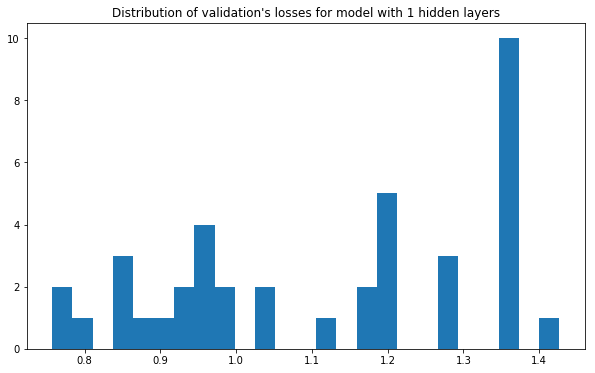

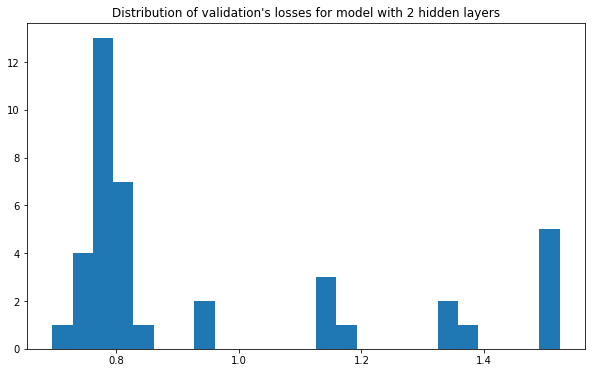

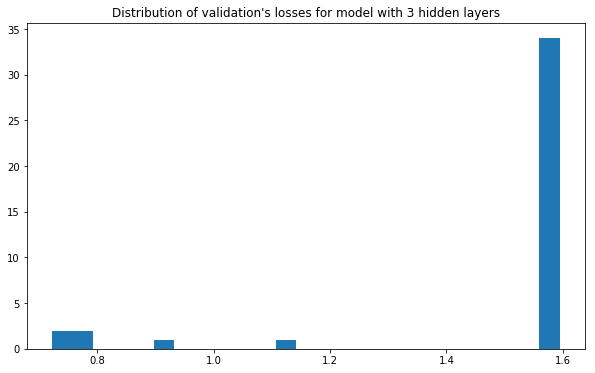

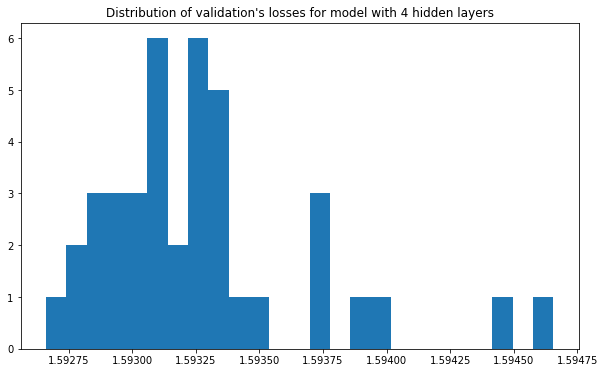

In [14]:
for i, model_results in enumerate(best_results):
    val_loss, val_acc = list(zip(*model_results))
    plt.hist(val_loss, bins=25)
    plt.title("Distribution of validation's losses for model with " + str(i+1) + " hidden layers")
    plt.show()

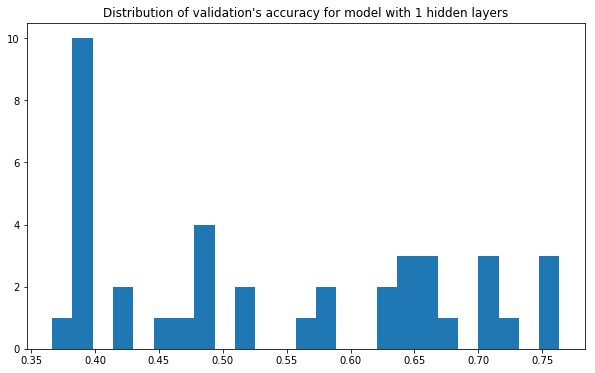

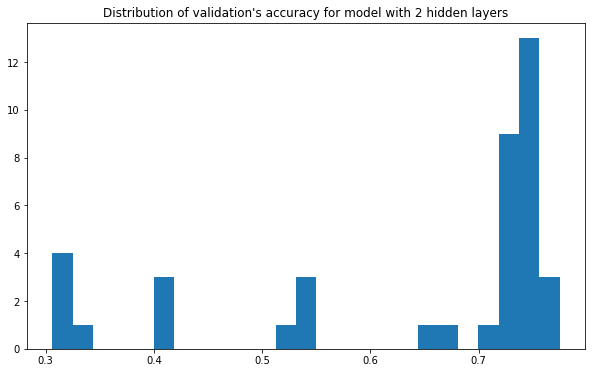

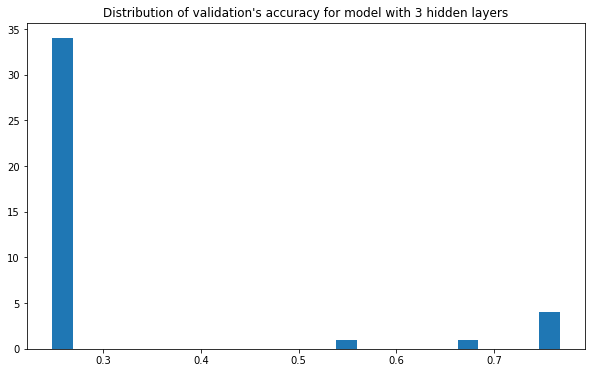

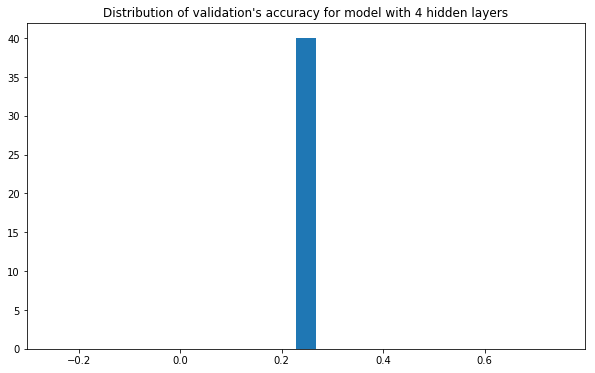

In [15]:
for i, model_results in enumerate(best_results):
    val_loss, val_acc = list(zip(*model_results))
    plt.hist(val_acc, bins=25)
    plt.title("Distribution of validation's accuracy for model with " + str(i+1) + " hidden layers")
    plt.show()

In [60]:
best_trainings = []

for model_results in results:
    best_accs = [max(training_history.history['val_acc']) for training_history in model_results]
    best_training = model_results[best_accs.index(max(best_accs))]
    best_trainings.append(best_training)

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [16]:
weight_l1_regularizations = [10, 1.0, 0.1, 0.01, 0.001]
weight_l2_regularizations = [10, 1.0, 0.1, 0.01, 0.001]

bias_l1_regularizations = [10, 1.0, 0.1, 0.01, 0.001]
bias_l2_regularizations = [10, 1.0, 0.1, 0.01, 0.001]

dropouts = [[0.2, 0.5], [0.2, 0.9], [0.1, 0.1]]

def grid_search(model_factory, compiler, model_fiter):
    histories = []
    
    def inner_loop(*param_lists):
        for w_reg, b_reg, dropout in itertools.product(*param_lists):
            print(w_reg, b_reg, dropout)
            model = model_factory(keras.regularizers.l1(w_reg), keras.regularizers.l1(b_reg), dropout=dropout)
            compiler(model)
            h = model_fiter(model)
            histories.append(h)
            
    inner_loop(weight_l1_regularizations, bias_l1_regularizations, dropouts)
    inner_loop(weight_l2_regularizations, bias_l1_regularizations, dropouts)
    inner_loop(weight_l1_regularizations, bias_l2_regularizations, dropouts)
    inner_loop(weight_l2_regularizations, bias_l2_regularizations, dropouts)
    
    return histories

In [17]:
model_family = [model_1_hidden_factory, model_4_hidden_factory]

results = []
for model in model_family:
    res = grid_search(model, compile_model, fit_model)
    results.append(res)

10 10 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 10s 350us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 129us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 130us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 131us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 137us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 10 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 9s 307us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 133us/step -

29639/29639 [==============================] - 4s 132us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.01 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 9s 320us/step - loss: 379.7845 - acc: 0.2473 - val_loss: 323.1224 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 132us/step - loss: nan - acc: 0.2513 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 128us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 142us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 127us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 4s 127us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.001

29639/29639 [==============================] - 4s 129us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 130us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.1 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 10s 331us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 132us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 132us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 130us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 132us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.1 [0.1, 0.1

Epoch 2/80
29639/29639 [==============================] - 4s 134us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 135us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 136us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 135us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 10 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 10s 346us/step - loss: nan - acc: 0.2347 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 136us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 136us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4

29639/29639 [==============================] - 4s 143us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 0.001 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 11s 381us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 4s 142us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 142us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 142us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 143us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 0.001 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 11s 376us/step - l

29639/29639 [==============================] - 4s 145us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 11s 386us/step - loss: 3.3354 - acc: 0.2275 - val_loss: 1.9344 - val_acc: 0.1630
Epoch 2/80
29639/29639 [==============================] - 4s 147us/step - loss: nan - acc: 0.2308 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 4s 146us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 4s 147us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 4s 148us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 4s 150us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.01 

29639/29639 [==============================] - 5s 153us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 1.0 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 12s 403us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 156us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 156us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 5s 158us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 154us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 1.0 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 12s 404us/step - l

Epoch 2/80
29639/29639 [==============================] - 5s 159us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 157us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 5s 159us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 166us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 0.001 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 14s 460us/step - loss: 3.0170 - acc: 0.2477 - val_loss: 1.6268 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 177us/step - loss: 3.0489 - acc: 0.2454 - val_loss: 1.6262 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 165us/step - loss: 2.9640 - acc: 0.2481 - val_loss: 1.6262 - 

29639/29639 [==============================] - 13s 440us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 168us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 164us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 5s 164us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 169us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 13s 440us/step - loss: 378.6545 - acc: 0.2237 - val_loss: 328.7249 - val_acc: 0.2342
Epoch 2/80
29639/29639 [==============================] - 5s 164us/step - loss: 342.6657 - acc: 0.2250 - val_loss: 347.8906 - val_acc: 0.24

29639/29639 [==============================] - 5s 170us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 172us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 10 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 14s 461us/step - loss: 41.9626 - acc: 0.2008 - val_loss: 34.9287 - val_acc: 0.2342
Epoch 2/80
29639/29639 [==============================] - 5s 170us/step - loss: 38.2410 - acc: 0.2007 - val_loss: 37.2991 - val_acc: 0.1983
Epoch 3/80
29639/29639 [==============================] - 5s 174us/step - loss: nan - acc: 0.2495 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 5s 169us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 169us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Ep

29639/29639 [==============================] - 14s 487us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 180us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 178us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 5s 181us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 178us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.001 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 14s 482us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 177us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
296

0.1 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 15s 504us/step - loss: nan - acc: 0.2378 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 6s 187us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 5s 183us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 186us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 5s 184us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 0.01 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 15s 503us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 5s 183us/

29639/29639 [==============================] - 6s 190us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 1.0 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 15s 522us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 6s 188us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 6s 191us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 188us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 6s 187us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 1.0 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 15s 514us/step - los

29639/29639 [==============================] - 6s 189us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 194us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 6s 192us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.001 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 16s 528us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 6s 193us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 240us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 226us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
296

Epoch 2/80
29639/29639 [==============================] - 6s 196us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 6s 195us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 194us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 6s 199us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 0.01 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 17s 559us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 240us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 241us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epo

29639/29639 [==============================] - 6s 206us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 6s 204us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 200us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 6s 206us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 1.0 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 17s 575us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 6s 203us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 6s 201us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/2

29639/29639 [==============================] - 18s 595us/step - loss: 377.1460 - acc: 0.2458 - val_loss: 328.1892 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 233us/step - loss: 341.0811 - acc: 0.2490 - val_loss: 344.8335 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 233us/step - loss: 341.0098 - acc: 0.2509 - val_loss: 336.5324 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 234us/step - loss: 340.9588 - acc: 0.2440 - val_loss: 333.7834 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 7s 233us/step - loss: 341.0492 - acc: 0.2481 - val_loss: 358.5252 - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 7s 233us/step - loss: 340.9478 - acc: 0.2497 - val_loss: 317.0765 - val_acc: 0.2478
Epoch 7/80
29639/29639 [==============================] - 7s 233us/step - loss: 340.9033 - acc: 0.2488 - val_loss: 345.7342 - val_acc: 0.2478
Epoch 8/80
29639

29639/29639 [==============================] - 7s 239us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 7s 239us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 18s 609us/step - loss: 40.6111 - acc: 0.2265 - val_loss: 32.8444 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 238us/step - loss: 36.8335 - acc: 0.2272 - val_loss: 36.9787 - val_acc: 0.1983
Epoch 3/80
29639/29639 [==============================] - 7s 237us/step - loss: 36.8995 - acc: 0.2198 - val_loss: 34.4007 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 237us/step - loss: nan - acc: 0.2264 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 7s 238us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 

Epoch 2/80
29639/29639 [==============================] - 7s 227us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 227us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 259us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 265us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 1.0 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 20s 664us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 243us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 278us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 

29639/29639 [==============================] - 8s 278us/step - loss: 6.4271 - acc: 0.2464 - val_loss: 5.0346 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 280us/step - loss: 6.3712 - acc: 0.2456 - val_loss: 4.9971 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 280us/step - loss: 6.3655 - acc: 0.2465 - val_loss: 4.9462 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 278us/step - loss: 6.3372 - acc: 0.2476 - val_loss: 5.2382 - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 8s 279us/step - loss: nan - acc: 0.2502 - val_loss: nan - val_acc: 0.2478
0.01 10 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 20s 681us/step - loss: nan - acc: 0.2514 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 238us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 

29639/29639 [==============================] - 7s 219us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.01 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 20s 666us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 235us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 249us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 241us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 7s 249us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.01 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 20s 663us/step - l

Epoch 3/80
29639/29639 [==============================] - 8s 265us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 264us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 265us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 1.0 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 21s 696us/step - loss: nan - acc: 0.2472 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 232us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 6s 218us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 6s 219us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoc

29639/29639 [==============================] - 7s 227us/step - loss: nan - acc: 0.2500 - val_loss: nan - val_acc: 0.2478
Epoch 8/80
29639/29639 [==============================] - 7s 241us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 10 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 22s 754us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 287us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 234us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 285us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 274us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 10 [0.2, 0.9]
Tr

29639/29639 [==============================] - 7s 246us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 234us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 7s 232us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.01 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 23s 768us/step - loss: 380.4083 - acc: 0.2481 - val_loss: 326.7795 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 7s 251us/step - loss: nan - acc: 0.2502 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 7s 239us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 7s 239us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5

29639/29639 [==============================] - 9s 294us/step - loss: 38.5230 - acc: 0.2026 - val_loss: 39.0359 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 264us/step - loss: 38.5011 - acc: 0.2024 - val_loss: 36.4916 - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 272us/step - loss: 38.4562 - acc: 0.2047 - val_loss: 37.3531 - val_acc: 0.1567
Epoch 5/80
29639/29639 [==============================] - 7s 248us/step - loss: 38.4970 - acc: 0.1964 - val_loss: 39.4567 - val_acc: 0.1983
Epoch 6/80
29639/29639 [==============================] - 7s 251us/step - loss: 38.4887 - acc: 0.2010 - val_loss: 34.5088 - val_acc: 0.2478
Epoch 7/80
29639/29639 [==============================] - 8s 279us/step - loss: nan - acc: 0.2245 - val_loss: nan - val_acc: 0.2478
Epoch 8/80
29639/29639 [==============================] - 8s 273us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 9/80
29639/29639 [=======================

0.1 10 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 22s 745us/step - loss: nan - acc: 0.2514 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 297us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 285us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 9s 290us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 9s 298us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 10 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 23s 771us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 299us/ste

29639/29639 [==============================] - 8s 267us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 0.01 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 24s 796us/step - loss: 6.8782 - acc: 0.2462 - val_loss: 4.7757 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 8s 285us/step - loss: 6.3902 - acc: 0.2472 - val_loss: 5.2312 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 265us/step - loss: 6.4401 - acc: 0.2483 - val_loss: 5.0073 - val_acc: 0.2342
Epoch 4/80
29639/29639 [==============================] - 8s 259us/step - loss: 6.4424 - acc: 0.2472 - val_loss: 5.1097 - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 254us/step - loss: 6.4277 - acc: 0.2461 - val_loss: 5.2396 - val_acc: 0.2342
Epoch 6/80
29639/29639 [==============================] - 8s 269us/step - loss: 6.3954 - acc: 0.2485 - val_loss: 4.843

29639/29639 [==============================] - 8s 275us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 266us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 258us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 260us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.1 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 23s 769us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 8s 258us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 258us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639

29639/29639 [==============================] - 8s 264us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 10 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 25s 830us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 303us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 257us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 8s 266us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 8s 269us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 10 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 25s 848us/step - los

Epoch 3/80
29639/29639 [==============================] - 9s 291us/step - loss: nan - acc: 0.2518 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 9s 300us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 9s 298us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 9s 295us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 0.001 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 24s 823us/step - loss: nan - acc: 0.2515 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 8s 279us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 8s 273us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Ep

29639/29639 [==============================] - 27s 910us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 307us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 10s 328us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 9s 309us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 9s 307us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 30s 1ms/step - loss: nan - acc: 0.2481 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 10s 335us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/

29639/29639 [==============================] - 10s 322us/step - loss: 39.3394 - acc: 0.2042 - val_loss: 35.1543 - val_acc: 0.2478
Epoch 7/80
29639/29639 [==============================] - 9s 309us/step - loss: 39.3475 - acc: 0.2007 - val_loss: 39.4982 - val_acc: 0.2342
Epoch 8/80
29639/29639 [==============================] - 10s 351us/step - loss: 39.3291 - acc: 0.2014 - val_loss: 36.4191 - val_acc: 0.1567
Epoch 9/80
29639/29639 [==============================] - 10s 332us/step - loss: 39.3387 - acc: 0.2078 - val_loss: 38.9050 - val_acc: 0.2342
Epoch 10/80
29639/29639 [==============================] - 10s 337us/step - loss: 39.3228 - acc: 0.2005 - val_loss: 38.0135 - val_acc: 0.2478
Epoch 11/80
29639/29639 [==============================] - 9s 314us/step - loss: nan - acc: 0.2258 - val_loss: nan - val_acc: 0.2478
1.0 1.0 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 29s 974us/step - loss: nan - acc: 0.2516 - val

29639/29639 [==============================] - 12s 388us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.001 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 29s 984us/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 11s 387us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 12s 418us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 12s 393us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 10s 349us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
1.0 0.001 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 30s 997us/ste

Epoch 2/80
29639/29639 [==============================] - 12s 401us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 12s 401us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 14s 458us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 12s 401us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.1 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 32s 1ms/step - loss: 6.7603 - acc: 0.2249 - val_loss: 4.8566 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 11s 356us/step - loss: 6.3861 - acc: 0.2194 - val_loss: 5.0639 - val_acc: 0.1567
Epoch 3/80
29639/29639 [==============================] - 10s 341us/step - loss: nan - acc: 0.2351 - val_loss: nan - val_ac

29639/29639 [==============================] - 29s 990us/step - loss: nan - acc: 0.2327 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 294us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 9s 290us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 9s 292us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 9s 292us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 1.0 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 29s 994us/step - loss: nan - acc: 0.2513 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 9s 302us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
2963

29639/29639 [==============================] - 11s 361us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 11s 360us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.001 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 34s 1ms/step - loss: nan - acc: 0.2517 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 11s 368us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 11s 379us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 14s 458us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 13s 447us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.01 0.001

Epoch 3/80
29639/29639 [==============================] - 11s 354us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 10s 352us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 10s 342us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
0.001 0.1 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 31s 1ms/step - loss: 3.0948 - acc: 0.2327 - val_loss: 1.6669 - val_acc: 0.2342
Epoch 2/80
29639/29639 [==============================] - 9s 306us/step - loss: 3.0154 - acc: 0.2441 - val_loss: 1.6691 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 9s 319us/step - loss: 3.0738 - acc: 0.2396 - val_loss: 1.6788 - val_acc: 0.1983
Epoch 4/80
29639/29639 [==============================] - 9s 300us/step - loss: 3.0808 - acc: 0.2374 - val_loss: 1.67

Epoch 6/80
29639/29639 [==============================] - 10s 341us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 1.0 [0.2, 0.5]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 33s 1ms/step - loss: nan - acc: 0.2514 - val_loss: nan - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 10s 340us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 10s 336us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 10s 343us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 10s 332us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 1.0 [0.2, 0.9]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 33s 1ms/st

Epoch 5/80
29639/29639 [==============================] - 10s 347us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
10 0.001 [0.1, 0.1]
Train on 29639 samples, validate on 10181 samples
Epoch 1/80
29639/29639 [==============================] - 34s 1ms/step - loss: 391.1533 - acc: 0.2438 - val_loss: 325.3380 - val_acc: 0.2478
Epoch 2/80
29639/29639 [==============================] - 10s 350us/step - loss: 352.7792 - acc: 0.2461 - val_loss: 364.4195 - val_acc: 0.2478
Epoch 3/80
29639/29639 [==============================] - 10s 345us/step - loss: nan - acc: 0.2488 - val_loss: nan - val_acc: 0.2478
Epoch 4/80
29639/29639 [==============================] - 10s 350us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 5/80
29639/29639 [==============================] - 10s 354us/step - loss: nan - acc: 0.2516 - val_loss: nan - val_acc: 0.2478
Epoch 6/80
29639/29639 [==============================] - 10s 348us/step - loss: nan - acc: 0.2516 - val_loss: nan

KeyboardInterrupt: 

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution